In [ ]:
# Imports
import torch
from torch import nn

import torchmetrics

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [176]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Food Vision Mini
---
This is a small version of a food-classfication project which classifies an image as pizza, steak or sushi.

The data used for this project is from Food-101 dataset which contains 101 different food classes with 1000 images per class including both trianing and testing.

Our dataset contains only 3 different classes (pizza, steak, sushi) and only 10% of the images.

## Data Download

In [177]:
# Downloading the data -> pizza, steak, sushi
import requests
from pathlib import Path
import zipfile

data_path = Path('./data/')

# Check if the folder already exists
if data_path.is_dir():
    print(f"Data has already been downloaded.")
else:
    data_path.mkdir(parents=True, exist_ok=True)
    
    print("Downloading data...\n\n")
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(data_path)
    
    print("Download successful.")

Data has already been downloaded.


## Data Preperation and Exploration

In [178]:
# Walkthrough the data folder
import os

def walk_through_dir(dir_path):
    """
    The function goes through all the directories and files of the given root directory.
    It prints the number of directories and files that are in a directory starting at the root until the deepest dir.
    
    Args:
        dir_path: A Path file which contains the path for the root directory.
        
    Returns:
        None
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

In [179]:
walk_through_dir(data_path)

There are 2 directories and 1 in data
There are 3 directories and 0 in data/test
There are 0 directories and 19 in data/test/steak
There are 0 directories and 25 in data/test/pizza
There are 0 directories and 31 in data/test/sushi
There are 3 directories and 0 in data/train
There are 0 directories and 75 in data/train/steak
There are 0 directories and 78 in data/train/pizza
There are 0 directories and 72 in data/train/sushi


### Data Class Summary

- Pizza: 78 Train / 25 Test

- Steak: 75 Train / 19 Test

- Sushi: 72 Train / 31 Test

## Random Visualization

In [180]:
# Random data visualization
import random

# list of all the paths of the images in the data folder
image_paths = list(data_path.glob('*/*/*.jpg'))

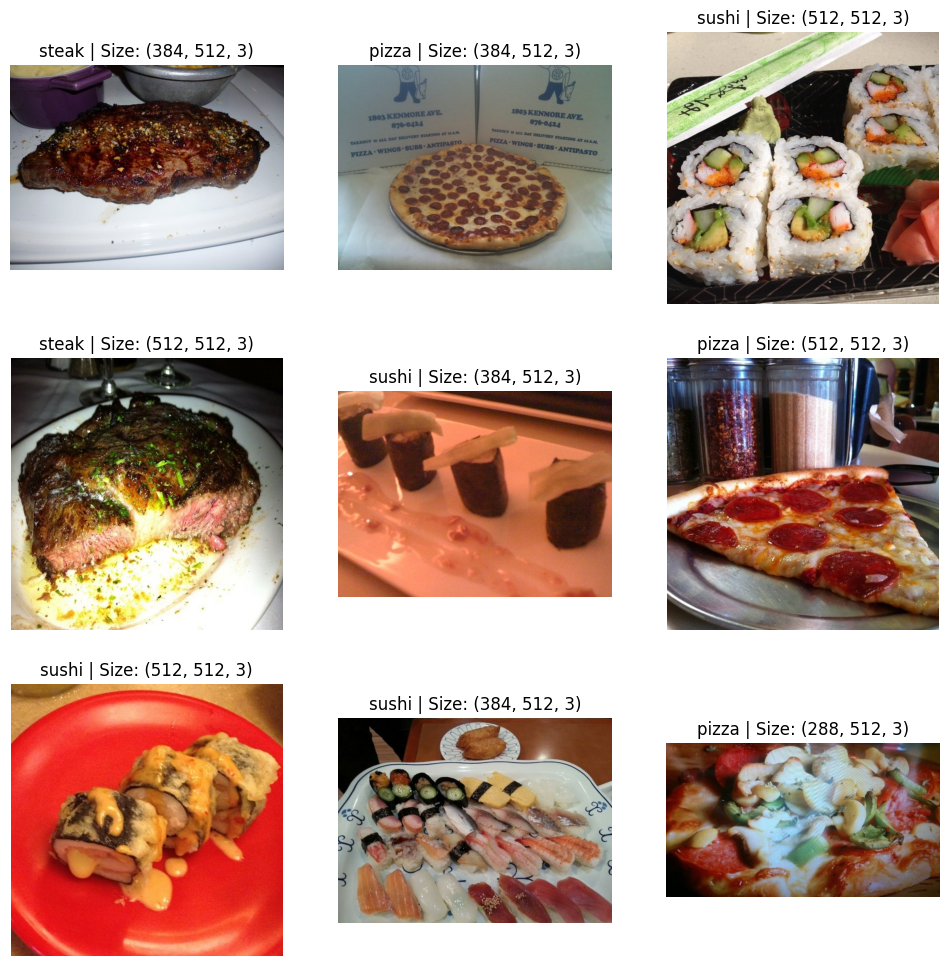

In [181]:
# Random images using matplotlib
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 3

random_image_paths = random.choices(image_paths, k=rows*cols)

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    img = np.asarray(img)
    
    fig.add_subplot(rows, cols, i+1)
    
    plt.imshow(img)
    plt.title(f"{str(path.parent.stem)} | Size: {img.shape}")
    plt.axis(False)

## Transformations

In [182]:
train_data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size = (64, 64)),
    # Flip
    transforms.RandomHorizontalFlip(p = 0.5),   # probability = 50%
    # Image to tensor
    transforms.ToTensor(),
])

test_data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size = (64, 64)),
    # Image to tensor
    transforms.ToTensor(),
])

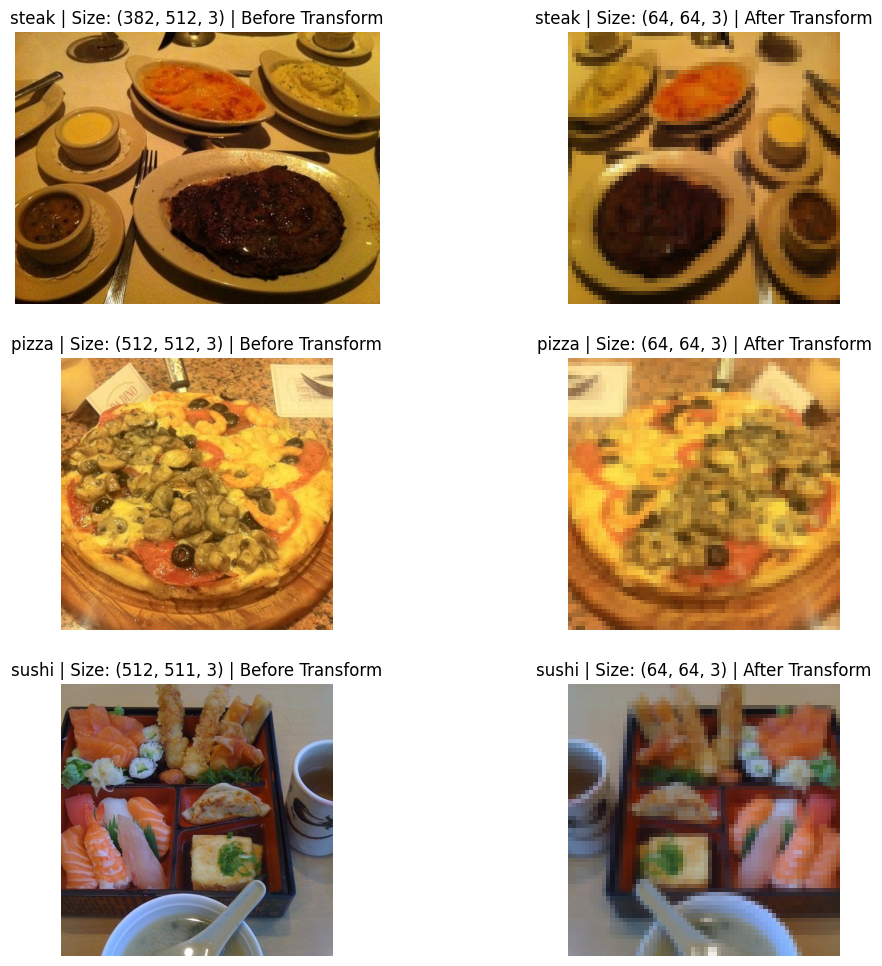

In [183]:
# Compare random images using matplotlib before and after transform
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 2
subplot_num = 0

random_image_paths = random.choices(image_paths, k=int((rows*cols)/2))

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    
    img_no_transform = np.asarray(img)
    img_transform = np.asarray(train_data_transform(img).permute(1,2,0))
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_no_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_no_transform.shape} | Before Transform")
    plt.axis(False)
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_transform.shape} | After Transform")
    plt.axis(False)

### Data discrepency notes:

- Image shapes vary (Random image visualization)
    - Dealt with the issue using Resize() transform

- There are mismatches between pictures and labels. <br>
eg: A picture of a cup labeled as pizza, fries as pizza (Random image visualization)

## Loading image data using ImageFolder

In [184]:
# Setting train and test directories
train_dir = data_path / 'train'
test_dir = data_path / 'test'

In [185]:
# Loading the datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)            # No transformation for labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform,
                                 target_transform=None)

print(train_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [186]:
# Loading datasets to dataloaders
batch_size = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=4,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size * 2,
                             num_workers=4,
                             shuffle=True)

In [187]:
# Creating variables for class information
class_names = train_data.classes
class_names_dict = train_data.class_to_idx

print(class_names)
print()
print(class_names_dict)

['pizza', 'steak', 'sushi']

{'pizza': 0, 'steak': 1, 'sushi': 2}


## Loading images using a custom `Dataset` class

When: <br>
    <ul> - To be used when the `data` has a custom structure.</ul>
    <ul> - More flexibility.</ul>

What: <br>
    <ul> - A custom class to extract data from the `data` folder.</ul>

In [188]:
# Necessary imports
import os
from typing import Tuple, Dict, List

In [189]:
# Creating a function to find classes within the data directory
def find_classes(directory: Path) -> Tuple[List[str], Dict[str, int]]:
    """
    A function that returns a list of class names and a dictionary of class names and its indices /
    given a directory with data.
    
    Args:
        directory: The path of the directory with the class names. It can be both a 'str' or a 'Path' object.
        
    Returns: 
        A tuple with - [List of class names] and {Dictionary with class names and its indices}.
    
    Raises:
        FileNotFoundError when there are no directories found in the given path.
    """
    class_names = sorted([entry.name for entry in os.scandir(directory)])
    
    if not class_names:
        raise FileNotFoundError("No directories found in the given path. Please check the structure.")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    
    return class_names, class_to_idx

Functionality to include:
- Have `paths` which holds all the paths of our data.
- Capable of `transforms` if there is a list of transforms being passed.
- Have a list of class names.
- Have a dictionary with class names and thier class indices.
- Function to open an image called `load_image()`.
- Overwrite both `len` and `getitem` dunder methods. 

In [190]:
# Creating a custom Dataset object replicating ImageFolder
class CustomImageFolder(Dataset):
    def __init__(self,
                 directory: Path,
                 transforms = None) -> None:
        super().__init__()
        
        self.paths = list(directory.glob("*/*.jpg"))
        self.transforms = transforms
        self.classes, self.class_to_idx = find_classes(directory)
        
    def load_image(self, index: int) -> Image.Image:
        """
        To open an image given an index of the datapoint.
        """
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        """
        Return total number of samples in the class instance
        """
        return len(self.paths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """
        Returns on datapoint given an index -> (data, label) 
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_index = self.class_to_idx[class_name]
        
        # Transform
        if self.transforms:
            return self.transforms(img), class_index
        else:
            return transforms.functional.pil_to_tensor(img), class_index

In [191]:
# Testing out the custom class
custom_train_data = CustomImageFolder(directory=train_dir,
                                      transforms=train_data_transform)

print(custom_train_data.class_to_idx)
print()
print(custom_train_data.classes)
print()
print(len(custom_train_data))
print()
print(custom_train_data.paths[:2])
print()
print(custom_train_data.__getitem__(1))

{'pizza': 0, 'steak': 1, 'sushi': 2}

['pizza', 'steak', 'sushi']

225

[PosixPath('data/train/steak/167069.jpg'), PosixPath('data/train/steak/1264154.jpg')]

(tensor([[[0.2431, 0.2706, 0.3098,  ..., 0.0980, 0.1412, 0.2941],
         [0.2000, 0.2275, 0.2824,  ..., 0.1098, 0.1725, 0.3647],
         [0.2353, 0.2118, 0.2431,  ..., 0.1176, 0.2118, 0.4314],
         ...,
         [0.1059, 0.0902, 0.0471,  ..., 0.2392, 0.2667, 0.2549],
         [0.0863, 0.0784, 0.0471,  ..., 0.2078, 0.2275, 0.2314],
         [0.0902, 0.0863, 0.0549,  ..., 0.1451, 0.1490, 0.1569]],

        [[0.1020, 0.1216, 0.1490,  ..., 0.0314, 0.0510, 0.2314],
         [0.0745, 0.0980, 0.1373,  ..., 0.0314, 0.0824, 0.3098],
         [0.1020, 0.0824, 0.1098,  ..., 0.0314, 0.1176, 0.3882],
         ...,
         [0.0392, 0.0392, 0.0235,  ..., 0.1137, 0.1373, 0.1216],
         [0.0392, 0.0314, 0.0235,  ..., 0.0980, 0.1137, 0.1137],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0706]],

        [[0.0706, 0.0667, 0.

In [192]:
# Turning custom dataset to dataloder
custom_train_dataloader = DataLoader(dataset=custom_train_data,
                                     batch_size=16,
                                     shuffle=True,
                                     num_workers=0)

custom_img, custom_lable = next(iter(custom_train_dataloader))
print(custom_img.shape)

torch.Size([16, 3, 64, 64])


# Data Augmentation

- Artificially adding diversity to training data.
- For images, its applying different transformations from the transforms library.
- This is done to generalize the model making it better with unseen data.
- Ex: rotate, flip, crop and more.
---
- Trivial augment wide.
- Used to train SOTA models by the pytorch team.

In [193]:
# Using trivial augment for our data transforms

train_data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
])

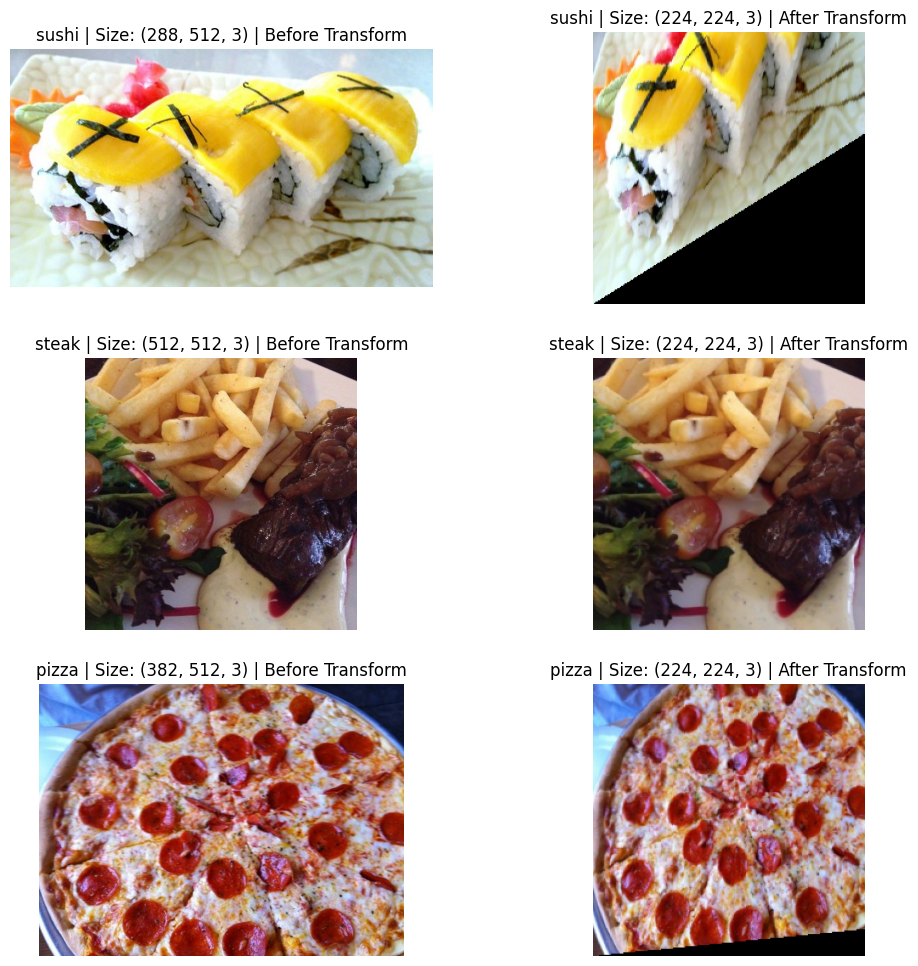

In [194]:
# Compare random images using matplotlib before and after transform
fig = plt.figure(figsize = (12, 12))
rows, cols = 3, 2
subplot_num = 0

random_image_paths = random.choices(image_paths, k=int((rows*cols)/2))

for i, path in enumerate(random_image_paths):
    img = Image.open(path)
    
    img_no_transform = np.asarray(img)
    img_transform = np.asarray(train_data_transform(img).permute(1,2,0))
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_no_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_no_transform.shape} | Before Transform")
    plt.axis(False)
    
    subplot_num += 1
    fig.add_subplot(rows, cols, subplot_num)
    plt.imshow(img_transform)
    plt.title(f"{str(path.parent.stem)} | Size: {img_transform.shape} | After Transform")
    plt.axis(False)

# Model

In [195]:
# Building the model with Tiny VGG architecture
class TinyVGGMiniFoodModel(nn.Module):
    """
    A model with the TinyVGG architecture. Will be used to train a model for image classification.
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                      out_features=output_shape),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

# Training Functions

In [196]:
# Function with a train loop per epoch
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                loss_function: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Dict:
    """
    This function goes through the entire dataloader and performs a gradient descent for every batch.
    
    Args:
        model: The model to be trained. Subclasses torch.nn.Module class.
        dataloader: A dataloader that contains the training dataset as a DataLoader object.
        loss_function: A function to calculate the loss and perform backward pass.
        optimizer: An optmizer to perform gradient descent.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - Average training loss for the entire epoch.
    """
    # Set model to train mode
    model.train()
    
    # Variable to trace loss
    train_loss = 0
    
    # Move model to device
    model = model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        # Move data to device
        X = X.to(device)
        y = y.to(device)
        
        # Change dtype
        y = y.to(torch.long)
        
        # Forward Pass -> Loss -> Zero Grad ->  Back Propagation -> Gradient Descent
        y_preds = model(X)
        loss = loss_function(y_preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss
    
    train_loss /= len(dataloader)
    return {"train_loss": train_loss.item()}

In [197]:
# Function with test loop per epoch
def test_epoch(model: nn.Module,
               dataloader: DataLoader,
               loss_function: nn.Module,
               accuracy_function: torchmetrics.Accuracy,
               device: torch.device) -> Dict:
    """
    This function goes through the entire dataloader and tests the model.
    
    Args:
        model: The model to be tested. Subclasses torch.nn.Module class.
        dataloader: A dataloader that contains the testing dataset as a DataLoader object.
        loss_function: A function to calculate the loss.
        accuracy_function: Funciton to calculate accuracy.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - Average testing loss for the entire epoch.
            - Average testing accuracy for the entire epoch.
    """
    # Set the model to eval mode
    model.eval()
    
    # Variables to track loss and accuracy
    test_loss = 0
    test_accuracy = 0
    
    # Model and accuracy function to device
    model = model.to(device)
    accuracy_function = accuracy_function.to(device)
    
    for X, y in dataloader:
        # Data to device
        X = X.to(device)
        y = y.to(device)
        
        # Change dtype
        y = y.to(torch.long)
        
        # Forward pass, loss and accuracy
        y_pred = model(X)
        test_loss += loss_function(y_pred, y)
        test_accuracy += accuracy_function(torch.argmax(y_pred, dim = 1).squeeze(), y)
    
    # Average
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
    return {'test_loss': test_loss.item(),
            'test_accuracy': test_accuracy.item()}

In [198]:
# Function for a training loop given an epoch
from tqdm.auto import tqdm

def train_loop(epochs: int,
                model: nn.Module,
                train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                loss_function: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_function: torchmetrics.Accuracy,
                device: torch.device) -> Dict:
    """
    A function to train the given model on training data while performing testing with testing data for
    every epoch. 
    
    Args:
        epochs: Number of epochs the model goes through while training.
        model: The model to be tested. Subclasses torch.nn.Module class.
        train_dataloader: A dataloader that contains the training dataset as a DataLoader object.
        test_dataloader: A dataloader that contains the testing dataset as a DataLoader object.
        loss_function: A function to calculate the loss.
        optimizer: An optmizer to perform gradient descent.
        accuracy_function: Funciton to calculate accuracy.
        device: Device of choice for computations.
    
    Returns:
        Returns a dictionary object which contains: 
            - A list of training loss which was tracked during training.
            - A list of testing loss which was tracked during training.
            - A list of testing accuracy which was tracked during training.
    """
    results = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': []
    }
    
    # Run through every epoch
    for epoch in tqdm(range(epochs)):
        print(f"\nEPOCH: {epoch} ----------------------------------------------- \n")
        train_dict = train_epoch(model = model,
                                    dataloader=train_dataloader,
                                    loss_function=loss_function,
                                    optimizer=optimizer,
                                    device=device)
        test_dict = test_epoch(model=model,
                                  dataloader=test_dataloader,
                                  loss_function=loss_function,
                                  accuracy_function=accuracy_function,
                                  device=device)
    
        print(f"Epoch: {epoch}  |  Loss: {train_dict['train_loss']:.2f}  |  Test Loss: {test_dict['test_loss']:.2f}  |  Test Accuracy: {test_dict['test_accuracy']:.2f}")
        
        results['train_loss'].append(train_dict['train_loss'])
        results['test_loss'].append(test_dict['test_loss'])
        results['test_accuracy'].append(test_dict['test_accuracy'])
    
    return results

In [199]:
# Function to plot loss curves
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """
    A function to plot the loss curves given a dictionary with the relevant results.
    
    Args:
        results: A dictionary item which contains keys as - 'train_loss', 'test_loss' - and a list of 
            corresponding values for each epoch.
    
    Returns:
        None
    """
    # Get loss lists
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize = (6,4))
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

# Training

In [200]:
# A simple transform for the data
simple_data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [201]:
# Load and apply transforms
simple_train_data = datasets.ImageFolder(root=train_dir,
                                         transform=simple_data_transform)

simple_test_data = datasets.ImageFolder(root=test_dir,
                                        transform=simple_data_transform)

In [202]:
# Turn to DataLoaders
batch_size = 32
num_workers = 4

simple_train_dataloader = DataLoader(dataset=simple_train_data,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=num_workers)

simple_test_dataloader = DataLoader(dataset=simple_test_data,
                                    batch_size=batch_size * 2,
                                    shuffle=True,
                                    num_workers=num_workers)

In [203]:
# Instantiaing the model
from torchinfo import summary

model_no_augment = TinyVGGMiniFoodModel(input_shape=3,
                                        hidden_units=20,
                                        output_shape=len(class_names)).to(device)

summary(model_no_augment, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGMiniFoodModel                     [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 64, 64]           560
│    └─ReLU: 2-2                         [1, 20, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 20, 64, 64]           3,620
│    └─ReLU: 2-4                         [1, 20, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-7                         [1, 20, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 20, 32, 32]           3,620
│    └─ReLU: 2-9                         [1, 20, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 20, 16, 16]           --
├─Seq

In [204]:
# Loss function, optimizer, accuracy function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_no_augment.parameters(),
                             lr = 0.0001)
accuracy_function = torchmetrics.Accuracy(task='multiclass', num_classes=3)

In [205]:
# Training the model
results_no_augment = train_loop(epochs = 50,
                                model=model_no_augment,
                                train_dataloader=simple_train_dataloader,
                                test_dataloader=simple_test_dataloader,
                                loss_function=loss_function,
                                optimizer=optimizer,
                                accuracy_function=accuracy_function,
                                device=device)

  0%|          | 0/50 [00:00<?, ?it/s]


EPOCH: 0 ----------------------------------------------- 



  2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

Epoch: 0  |  Loss: 1.10  |  Test Loss: 1.10  |  Test Accuracy: 0.31

EPOCH: 1 ----------------------------------------------- 



  4%|▍         | 2/50 [00:01<00:27,  1.72it/s]

Epoch: 1  |  Loss: 1.09  |  Test Loss: 1.09  |  Test Accuracy: 0.46

EPOCH: 2 ----------------------------------------------- 



  6%|▌         | 3/50 [00:01<00:25,  1.84it/s]

Epoch: 2  |  Loss: 1.10  |  Test Loss: 1.10  |  Test Accuracy: 0.35

EPOCH: 3 ----------------------------------------------- 



  8%|▊         | 4/50 [00:02<00:24,  1.89it/s]

Epoch: 3  |  Loss: 1.10  |  Test Loss: 1.12  |  Test Accuracy: 0.31

EPOCH: 4 ----------------------------------------------- 



 10%|█         | 5/50 [00:02<00:23,  1.90it/s]

Epoch: 4  |  Loss: 1.09  |  Test Loss: 1.14  |  Test Accuracy: 0.23

EPOCH: 5 ----------------------------------------------- 



 12%|█▏        | 6/50 [00:03<00:22,  1.97it/s]

Epoch: 5  |  Loss: 1.09  |  Test Loss: 1.11  |  Test Accuracy: 0.29

EPOCH: 6 ----------------------------------------------- 



 14%|█▍        | 7/50 [00:03<00:21,  1.98it/s]

Epoch: 6  |  Loss: 1.11  |  Test Loss: 1.12  |  Test Accuracy: 0.38

EPOCH: 7 ----------------------------------------------- 



 16%|█▌        | 8/50 [00:04<00:21,  1.98it/s]

Epoch: 7  |  Loss: 1.08  |  Test Loss: 1.10  |  Test Accuracy: 0.44

EPOCH: 8 ----------------------------------------------- 



 18%|█▊        | 9/50 [00:04<00:20,  1.96it/s]

Epoch: 8  |  Loss: 1.07  |  Test Loss: 1.10  |  Test Accuracy: 0.31

EPOCH: 9 ----------------------------------------------- 



 20%|██        | 10/50 [00:05<00:20,  1.93it/s]

Epoch: 9  |  Loss: 1.08  |  Test Loss: 1.09  |  Test Accuracy: 0.35

EPOCH: 10 ----------------------------------------------- 



 22%|██▏       | 11/50 [00:05<00:20,  1.90it/s]

Epoch: 10  |  Loss: 1.08  |  Test Loss: 1.09  |  Test Accuracy: 0.41

EPOCH: 11 ----------------------------------------------- 



 24%|██▍       | 12/50 [00:06<00:20,  1.86it/s]

Epoch: 11  |  Loss: 1.07  |  Test Loss: 1.08  |  Test Accuracy: 0.49

EPOCH: 12 ----------------------------------------------- 



 26%|██▌       | 13/50 [00:06<00:19,  1.86it/s]

Epoch: 12  |  Loss: 1.05  |  Test Loss: 1.11  |  Test Accuracy: 0.38

EPOCH: 13 ----------------------------------------------- 



 28%|██▊       | 14/50 [00:07<00:19,  1.88it/s]

Epoch: 13  |  Loss: 1.06  |  Test Loss: 1.10  |  Test Accuracy: 0.39

EPOCH: 14 ----------------------------------------------- 



 30%|███       | 15/50 [00:07<00:18,  1.88it/s]

Epoch: 14  |  Loss: 1.02  |  Test Loss: 1.02  |  Test Accuracy: 0.54

EPOCH: 15 ----------------------------------------------- 



 32%|███▏      | 16/50 [00:08<00:17,  1.94it/s]

Epoch: 15  |  Loss: 1.04  |  Test Loss: 1.03  |  Test Accuracy: 0.45

EPOCH: 16 ----------------------------------------------- 



 34%|███▍      | 17/50 [00:08<00:16,  1.99it/s]

Epoch: 16  |  Loss: 0.96  |  Test Loss: 1.03  |  Test Accuracy: 0.46

EPOCH: 17 ----------------------------------------------- 



 36%|███▌      | 18/50 [00:09<00:16,  2.00it/s]

Epoch: 17  |  Loss: 1.02  |  Test Loss: 1.09  |  Test Accuracy: 0.43

EPOCH: 18 ----------------------------------------------- 



 38%|███▊      | 19/50 [00:09<00:15,  2.01it/s]

Epoch: 18  |  Loss: 0.87  |  Test Loss: 0.98  |  Test Accuracy: 0.50

EPOCH: 19 ----------------------------------------------- 



 40%|████      | 20/50 [00:10<00:15,  1.99it/s]

Epoch: 19  |  Loss: 1.00  |  Test Loss: 0.97  |  Test Accuracy: 0.48

EPOCH: 20 ----------------------------------------------- 



 42%|████▏     | 21/50 [00:10<00:14,  2.00it/s]

Epoch: 20  |  Loss: 0.93  |  Test Loss: 1.07  |  Test Accuracy: 0.32

EPOCH: 21 ----------------------------------------------- 



 44%|████▍     | 22/50 [00:11<00:14,  1.99it/s]

Epoch: 21  |  Loss: 0.98  |  Test Loss: 0.95  |  Test Accuracy: 0.42

EPOCH: 22 ----------------------------------------------- 



 46%|████▌     | 23/50 [00:11<00:13,  1.97it/s]

Epoch: 22  |  Loss: 0.90  |  Test Loss: 0.97  |  Test Accuracy: 0.46

EPOCH: 23 ----------------------------------------------- 



 48%|████▊     | 24/50 [00:12<00:13,  1.90it/s]

Epoch: 23  |  Loss: 0.87  |  Test Loss: 1.00  |  Test Accuracy: 0.42

EPOCH: 24 ----------------------------------------------- 



 50%|█████     | 25/50 [00:13<00:13,  1.89it/s]

Epoch: 24  |  Loss: 0.87  |  Test Loss: 1.03  |  Test Accuracy: 0.36

EPOCH: 25 ----------------------------------------------- 

Epoch: 25  |  Loss: 0.84  |  Test Loss: 1.04  |  Test Accuracy: 0.44

EPOCH: 26 ----------------------------------------------- 



 54%|█████▍    | 27/50 [00:13<00:09,  2.55it/s]

Epoch: 26  |  Loss: 0.91  |  Test Loss: 1.19  |  Test Accuracy: 0.30

EPOCH: 27 ----------------------------------------------- 



 56%|█████▌    | 28/50 [00:14<00:09,  2.31it/s]

Epoch: 27  |  Loss: 0.89  |  Test Loss: 1.03  |  Test Accuracy: 0.36

EPOCH: 28 ----------------------------------------------- 



 58%|█████▊    | 29/50 [00:14<00:09,  2.21it/s]

Epoch: 28  |  Loss: 0.76  |  Test Loss: 1.06  |  Test Accuracy: 0.45

EPOCH: 29 ----------------------------------------------- 



 60%|██████    | 30/50 [00:15<00:09,  2.17it/s]

Epoch: 29  |  Loss: 0.89  |  Test Loss: 0.90  |  Test Accuracy: 0.48

EPOCH: 30 ----------------------------------------------- 



 62%|██████▏   | 31/50 [00:15<00:08,  2.12it/s]

Epoch: 30  |  Loss: 0.84  |  Test Loss: 0.94  |  Test Accuracy: 0.46

EPOCH: 31 ----------------------------------------------- 



 64%|██████▍   | 32/50 [00:15<00:08,  2.14it/s]

Epoch: 31  |  Loss: 0.83  |  Test Loss: 0.95  |  Test Accuracy: 0.50

EPOCH: 32 ----------------------------------------------- 



 66%|██████▌   | 33/50 [00:16<00:08,  2.03it/s]

Epoch: 32  |  Loss: 0.73  |  Test Loss: 1.12  |  Test Accuracy: 0.37

EPOCH: 33 ----------------------------------------------- 



 68%|██████▊   | 34/50 [00:17<00:08,  1.98it/s]

Epoch: 33  |  Loss: 0.77  |  Test Loss: 0.98  |  Test Accuracy: 0.49

EPOCH: 34 ----------------------------------------------- 



 70%|███████   | 35/50 [00:17<00:07,  1.98it/s]

Epoch: 34  |  Loss: 0.82  |  Test Loss: 0.86  |  Test Accuracy: 0.52

EPOCH: 35 ----------------------------------------------- 



 72%|███████▏  | 36/50 [00:18<00:07,  2.00it/s]

Epoch: 35  |  Loss: 0.90  |  Test Loss: 1.04  |  Test Accuracy: 0.32

EPOCH: 36 ----------------------------------------------- 



 74%|███████▍  | 37/50 [00:18<00:06,  2.01it/s]

Epoch: 36  |  Loss: 0.77  |  Test Loss: 0.99  |  Test Accuracy: 0.49

EPOCH: 37 ----------------------------------------------- 



 76%|███████▌  | 38/50 [00:19<00:06,  1.96it/s]

Epoch: 37  |  Loss: 0.78  |  Test Loss: 1.04  |  Test Accuracy: 0.44

EPOCH: 38 ----------------------------------------------- 



 78%|███████▊  | 39/50 [00:19<00:05,  1.85it/s]

Epoch: 38  |  Loss: 0.87  |  Test Loss: 1.12  |  Test Accuracy: 0.39

EPOCH: 39 ----------------------------------------------- 



 80%|████████  | 40/50 [00:20<00:05,  1.83it/s]

Epoch: 39  |  Loss: 0.80  |  Test Loss: 1.05  |  Test Accuracy: 0.32

EPOCH: 40 ----------------------------------------------- 



 82%|████████▏ | 41/50 [00:20<00:04,  1.88it/s]

Epoch: 40  |  Loss: 0.78  |  Test Loss: 0.96  |  Test Accuracy: 0.48

EPOCH: 41 ----------------------------------------------- 



 84%|████████▍ | 42/50 [00:21<00:04,  1.94it/s]

Epoch: 41  |  Loss: 0.82  |  Test Loss: 0.92  |  Test Accuracy: 0.48

EPOCH: 42 ----------------------------------------------- 



 86%|████████▌ | 43/50 [00:21<00:03,  1.95it/s]

Epoch: 42  |  Loss: 0.76  |  Test Loss: 0.97  |  Test Accuracy: 0.47

EPOCH: 43 ----------------------------------------------- 



 88%|████████▊ | 44/50 [00:22<00:03,  1.93it/s]

Epoch: 43  |  Loss: 0.91  |  Test Loss: 1.02  |  Test Accuracy: 0.43

EPOCH: 44 ----------------------------------------------- 



 90%|█████████ | 45/50 [00:22<00:02,  1.95it/s]

Epoch: 44  |  Loss: 0.67  |  Test Loss: 1.13  |  Test Accuracy: 0.45

EPOCH: 45 ----------------------------------------------- 



 92%|█████████▏| 46/50 [00:23<00:02,  1.93it/s]

Epoch: 45  |  Loss: 0.71  |  Test Loss: 1.05  |  Test Accuracy: 0.43

EPOCH: 46 ----------------------------------------------- 



 94%|█████████▍| 47/50 [00:23<00:01,  1.98it/s]

Epoch: 46  |  Loss: 0.74  |  Test Loss: 1.01  |  Test Accuracy: 0.42

EPOCH: 47 ----------------------------------------------- 



 96%|█████████▌| 48/50 [00:24<00:01,  1.98it/s]

Epoch: 47  |  Loss: 0.67  |  Test Loss: 0.93  |  Test Accuracy: 0.44

EPOCH: 48 ----------------------------------------------- 



 98%|█████████▊| 49/50 [00:24<00:00,  1.99it/s]

Epoch: 48  |  Loss: 0.65  |  Test Loss: 1.08  |  Test Accuracy: 0.51

EPOCH: 49 ----------------------------------------------- 



100%|██████████| 50/50 [00:25<00:00,  1.97it/s]

Epoch: 49  |  Loss: 0.63  |  Test Loss: 1.07  |  Test Accuracy: 0.37


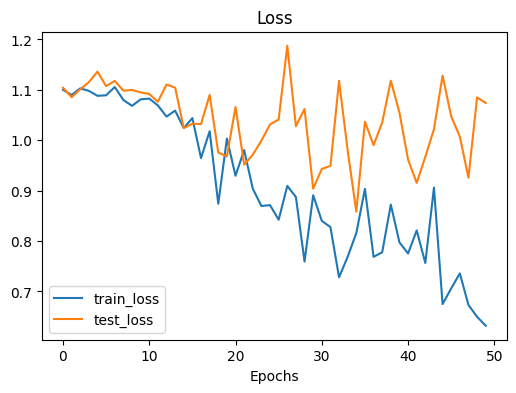

In [206]:
# Plotting the loss curves
plot_loss_curves(results_no_augment)

- The training loss declines over 25 epochs while the test loss stays arbitrary.
- The model is needs to be generalized.
- Use of regularization techniques.
- Use of data augmentation.

# Improvements

In [207]:
# Data transforms with augmentation
train_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [208]:
# Load datasets and apply transforms
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform)

In [209]:
# Datasets to dataloaders
import os
batch_size = 32
num_workers = int(os.cpu_count()/2)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size * 2,
                             num_workers=num_workers)

In [210]:
# Creating a model instance
from torchinfo import summary

model = TinyVGGMiniFoodModel(input_shape=3,
                             hidden_units=20,
                             output_shape=len(class_names)).to(device)

summary(model, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGMiniFoodModel                     [32, 3]                   --
├─Sequential: 1-1                        [32, 20, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 20, 64, 64]          560
│    └─ReLU: 2-2                         [32, 20, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 20, 64, 64]          3,620
│    └─ReLU: 2-4                         [32, 20, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 20, 32, 32]          --
├─Sequential: 1-2                        [32, 20, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-7                         [32, 20, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-9                         [32, 20, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 20, 16, 16]          --
├─Seq

In [211]:
# Loss function, optimizer, accuracy function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.0001)
accuracy_function = torchmetrics.Accuracy(task='multiclass', num_classes=3)

In [212]:
# Training the model
results = train_loop(epochs = 50,
                     model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_function=loss_function,
                     optimizer=optimizer,
                     accuracy_function=accuracy_function,
                     device=device)

  0%|          | 0/50 [00:00<?, ?it/s]


EPOCH: 0 ----------------------------------------------- 



  2%|▏         | 1/50 [00:00<00:38,  1.26it/s]

Epoch: 0  |  Loss: 1.10  |  Test Loss: 1.09  |  Test Accuracy: 0.20

EPOCH: 1 ----------------------------------------------- 



  4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

Epoch: 1  |  Loss: 1.10  |  Test Loss: 1.08  |  Test Accuracy: 0.66

EPOCH: 2 ----------------------------------------------- 



  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

Epoch: 2  |  Loss: 1.11  |  Test Loss: 1.07  |  Test Accuracy: 0.66

EPOCH: 3 ----------------------------------------------- 



  8%|▊         | 4/50 [00:03<00:34,  1.32it/s]

Epoch: 3  |  Loss: 1.10  |  Test Loss: 1.08  |  Test Accuracy: 0.66

EPOCH: 4 ----------------------------------------------- 



 10%|█         | 5/50 [00:03<00:34,  1.31it/s]

Epoch: 4  |  Loss: 1.10  |  Test Loss: 1.09  |  Test Accuracy: 0.66

EPOCH: 5 ----------------------------------------------- 



 12%|█▏        | 6/50 [00:04<00:33,  1.31it/s]

Epoch: 5  |  Loss: 1.10  |  Test Loss: 1.10  |  Test Accuracy: 0.15

EPOCH: 6 ----------------------------------------------- 



 14%|█▍        | 7/50 [00:05<00:33,  1.30it/s]

Epoch: 6  |  Loss: 1.09  |  Test Loss: 1.11  |  Test Accuracy: 0.15

EPOCH: 7 ----------------------------------------------- 



 16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

Epoch: 7  |  Loss: 1.10  |  Test Loss: 1.12  |  Test Accuracy: 0.15

EPOCH: 8 ----------------------------------------------- 



 18%|█▊        | 9/50 [00:06<00:29,  1.37it/s]

Epoch: 8  |  Loss: 1.10  |  Test Loss: 1.13  |  Test Accuracy: 0.15

EPOCH: 9 ----------------------------------------------- 



 20%|██        | 10/50 [00:07<00:28,  1.38it/s]

Epoch: 9  |  Loss: 1.09  |  Test Loss: 1.14  |  Test Accuracy: 0.20

EPOCH: 10 ----------------------------------------------- 



 22%|██▏       | 11/50 [00:08<00:28,  1.35it/s]

Epoch: 10  |  Loss: 1.11  |  Test Loss: 1.15  |  Test Accuracy: 0.20

EPOCH: 11 ----------------------------------------------- 



 24%|██▍       | 12/50 [00:09<00:28,  1.34it/s]

Epoch: 11  |  Loss: 1.11  |  Test Loss: 1.13  |  Test Accuracy: 0.22

EPOCH: 12 ----------------------------------------------- 



 26%|██▌       | 13/50 [00:09<00:27,  1.34it/s]

Epoch: 12  |  Loss: 1.09  |  Test Loss: 1.12  |  Test Accuracy: 0.22

EPOCH: 13 ----------------------------------------------- 



 28%|██▊       | 14/50 [00:10<00:26,  1.35it/s]

Epoch: 13  |  Loss: 1.10  |  Test Loss: 1.11  |  Test Accuracy: 0.20

EPOCH: 14 ----------------------------------------------- 



 30%|███       | 15/50 [00:11<00:24,  1.41it/s]

Epoch: 14  |  Loss: 1.09  |  Test Loss: 1.12  |  Test Accuracy: 0.24

EPOCH: 15 ----------------------------------------------- 



 32%|███▏      | 16/50 [00:11<00:23,  1.45it/s]

Epoch: 15  |  Loss: 1.09  |  Test Loss: 1.12  |  Test Accuracy: 0.20

EPOCH: 16 ----------------------------------------------- 



 34%|███▍      | 17/50 [00:12<00:21,  1.51it/s]

Epoch: 16  |  Loss: 1.10  |  Test Loss: 1.13  |  Test Accuracy: 0.20

EPOCH: 17 ----------------------------------------------- 



 36%|███▌      | 18/50 [00:13<00:21,  1.52it/s]

Epoch: 17  |  Loss: 1.10  |  Test Loss: 1.11  |  Test Accuracy: 0.20

EPOCH: 18 ----------------------------------------------- 



 38%|███▊      | 19/50 [00:13<00:20,  1.50it/s]

Epoch: 18  |  Loss: 1.08  |  Test Loss: 1.08  |  Test Accuracy: 0.41

EPOCH: 19 ----------------------------------------------- 



 40%|████      | 20/50 [00:14<00:20,  1.47it/s]

Epoch: 19  |  Loss: 1.09  |  Test Loss: 1.03  |  Test Accuracy: 0.65

EPOCH: 20 ----------------------------------------------- 



 42%|████▏     | 21/50 [00:15<00:20,  1.41it/s]

Epoch: 20  |  Loss: 1.08  |  Test Loss: 1.02  |  Test Accuracy: 0.66

EPOCH: 21 ----------------------------------------------- 



 44%|████▍     | 22/50 [00:15<00:20,  1.40it/s]

Epoch: 21  |  Loss: 1.08  |  Test Loss: 1.02  |  Test Accuracy: 0.65

EPOCH: 22 ----------------------------------------------- 



 46%|████▌     | 23/50 [00:16<00:19,  1.38it/s]

Epoch: 22  |  Loss: 1.09  |  Test Loss: 1.04  |  Test Accuracy: 0.50

EPOCH: 23 ----------------------------------------------- 



 48%|████▊     | 24/50 [00:17<00:18,  1.37it/s]

Epoch: 23  |  Loss: 1.06  |  Test Loss: 1.08  |  Test Accuracy: 0.27

EPOCH: 24 ----------------------------------------------- 



 50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

Epoch: 24  |  Loss: 1.06  |  Test Loss: 1.11  |  Test Accuracy: 0.24

EPOCH: 25 ----------------------------------------------- 



 52%|█████▏    | 26/50 [00:18<00:17,  1.36it/s]

Epoch: 25  |  Loss: 1.04  |  Test Loss: 1.13  |  Test Accuracy: 0.24

EPOCH: 26 ----------------------------------------------- 

Epoch: 26  |  Loss: 1.06  |  Test Loss: 1.13  |  Test Accuracy: 0.24

EPOCH: 27 ----------------------------------------------- 



 56%|█████▌    | 28/50 [00:19<00:12,  1.79it/s]

Epoch: 27  |  Loss: 1.04  |  Test Loss: 1.04  |  Test Accuracy: 0.46

EPOCH: 28 ----------------------------------------------- 



 58%|█████▊    | 29/50 [00:20<00:12,  1.64it/s]

Epoch: 28  |  Loss: 1.07  |  Test Loss: 1.06  |  Test Accuracy: 0.30

EPOCH: 29 ----------------------------------------------- 



 60%|██████    | 30/50 [00:21<00:12,  1.58it/s]

Epoch: 29  |  Loss: 0.97  |  Test Loss: 1.13  |  Test Accuracy: 0.31

EPOCH: 30 ----------------------------------------------- 



 62%|██████▏   | 31/50 [00:21<00:12,  1.53it/s]

Epoch: 30  |  Loss: 1.00  |  Test Loss: 1.17  |  Test Accuracy: 0.33

EPOCH: 31 ----------------------------------------------- 



 64%|██████▍   | 32/50 [00:22<00:12,  1.49it/s]

Epoch: 31  |  Loss: 1.05  |  Test Loss: 1.15  |  Test Accuracy: 0.29

EPOCH: 32 ----------------------------------------------- 



 66%|██████▌   | 33/50 [00:23<00:11,  1.45it/s]

Epoch: 32  |  Loss: 1.00  |  Test Loss: 1.04  |  Test Accuracy: 0.40

EPOCH: 33 ----------------------------------------------- 



 68%|██████▊   | 34/50 [00:23<00:10,  1.48it/s]

Epoch: 33  |  Loss: 0.98  |  Test Loss: 1.05  |  Test Accuracy: 0.40

EPOCH: 34 ----------------------------------------------- 



 70%|███████   | 35/50 [00:24<00:09,  1.51it/s]

Epoch: 34  |  Loss: 0.95  |  Test Loss: 1.15  |  Test Accuracy: 0.24

EPOCH: 35 ----------------------------------------------- 



 72%|███████▏  | 36/50 [00:25<00:09,  1.47it/s]

Epoch: 35  |  Loss: 1.03  |  Test Loss: 1.23  |  Test Accuracy: 0.24

EPOCH: 36 ----------------------------------------------- 



 74%|███████▍  | 37/50 [00:25<00:09,  1.44it/s]

Epoch: 36  |  Loss: 0.99  |  Test Loss: 1.16  |  Test Accuracy: 0.33

EPOCH: 37 ----------------------------------------------- 



 76%|███████▌  | 38/50 [00:26<00:08,  1.43it/s]

Epoch: 37  |  Loss: 0.97  |  Test Loss: 1.06  |  Test Accuracy: 0.46

EPOCH: 38 ----------------------------------------------- 



 78%|███████▊  | 39/50 [00:27<00:07,  1.43it/s]

Epoch: 38  |  Loss: 0.98  |  Test Loss: 1.11  |  Test Accuracy: 0.31

EPOCH: 39 ----------------------------------------------- 



 80%|████████  | 40/50 [00:28<00:07,  1.42it/s]

Epoch: 39  |  Loss: 0.96  |  Test Loss: 1.16  |  Test Accuracy: 0.30

EPOCH: 40 ----------------------------------------------- 



 82%|████████▏ | 41/50 [00:28<00:06,  1.44it/s]

Epoch: 40  |  Loss: 0.93  |  Test Loss: 1.17  |  Test Accuracy: 0.31

EPOCH: 41 ----------------------------------------------- 



 84%|████████▍ | 42/50 [00:29<00:05,  1.48it/s]

Epoch: 41  |  Loss: 0.96  |  Test Loss: 1.04  |  Test Accuracy: 0.46

EPOCH: 42 ----------------------------------------------- 



 86%|████████▌ | 43/50 [00:30<00:04,  1.45it/s]

Epoch: 42  |  Loss: 1.00  |  Test Loss: 0.97  |  Test Accuracy: 0.53

EPOCH: 43 ----------------------------------------------- 



 88%|████████▊ | 44/50 [00:30<00:04,  1.43it/s]

Epoch: 43  |  Loss: 1.07  |  Test Loss: 1.09  |  Test Accuracy: 0.31

EPOCH: 44 ----------------------------------------------- 



 90%|█████████ | 45/50 [00:31<00:03,  1.43it/s]

Epoch: 44  |  Loss: 0.92  |  Test Loss: 1.18  |  Test Accuracy: 0.33

EPOCH: 45 ----------------------------------------------- 



 92%|█████████▏| 46/50 [00:32<00:02,  1.49it/s]

Epoch: 45  |  Loss: 0.99  |  Test Loss: 1.19  |  Test Accuracy: 0.33

EPOCH: 46 ----------------------------------------------- 



 94%|█████████▍| 47/50 [00:32<00:02,  1.50it/s]

Epoch: 46  |  Loss: 1.02  |  Test Loss: 1.16  |  Test Accuracy: 0.33

EPOCH: 47 ----------------------------------------------- 



 96%|█████████▌| 48/50 [00:33<00:01,  1.51it/s]

Epoch: 47  |  Loss: 0.93  |  Test Loss: 1.01  |  Test Accuracy: 0.45

EPOCH: 48 ----------------------------------------------- 



 98%|█████████▊| 49/50 [00:34<00:00,  1.45it/s]

Epoch: 48  |  Loss: 0.93  |  Test Loss: 0.94  |  Test Accuracy: 0.54

EPOCH: 49 ----------------------------------------------- 



100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

Epoch: 49  |  Loss: 0.99  |  Test Loss: 1.01  |  Test Accuracy: 0.46


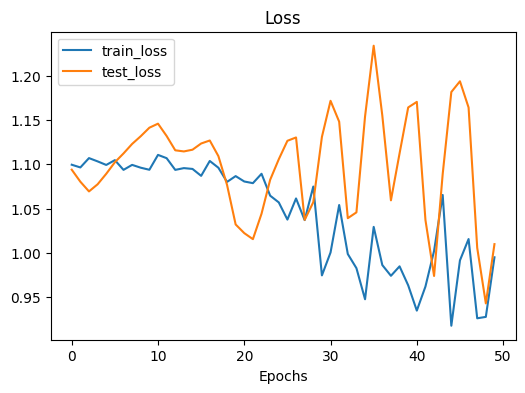

In [213]:
# Plotting the loss curves
plot_loss_curves(results)

- A Learning Rate scheduler has to be implemented by looking at the frequent ups and downs of the loss curves.
- Using dropout regularization will also help generalize the model.

---
- Other tools for comparing different model results
    - Torch tensorboard
    - Weights and Biases
    - MLFlow

# Predicting (Own Data)

In [261]:
import requests

test_image_path = data_path / 'pizza.jpg'

if not test_image_path.is_file():
    request = requests.get('https://cdn.loveandlemons.com/wp-content/uploads/2023/02/vegetarian-pizza.jpg')
    with open(test_image_path, 'wb') as f:
        f.write(request.content)
    print(f"Successfully downloaded the image.")
else:
    print(f"File already exists.")

File already exists.


Image shape: torch.Size([3, 1160, 1160])
Image shape: torch.uint8


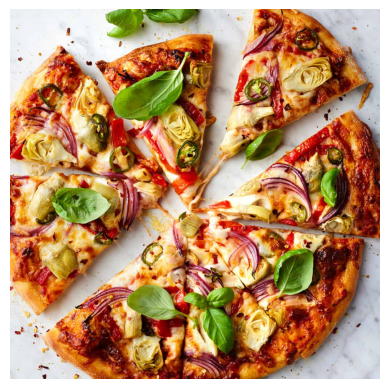

In [264]:
test_image = torchvision.io.read_image(test_image_path)
plt.imshow(test_image.permute(1, 2, 0))
plt.axis(False)

print(f"Image shape: {test_image.shape}")
print(f"Image shape: {test_image.dtype}")

In [265]:
# Checking the predicion of the model

# Normalizing the image
test_image = test_image / 255.

# Resizing the image
resize_transform = transforms.Resize(size = (64,64))
test_image = resize_transform(test_image)

# Adding the batch dimension
test_image = test_image.unsqueeze(dim = 0)

# Setting to eval mode
model = model.eval()

# Making prediciton and using argmax()
with torch.inference_mode():
    test_pred = model(test_image.to(device))
    test_pred = torch.argmax(test_pred, dim = 1).squeeze()
    print(f"Predicted class: {class_names[test_pred.item()]}")

Predicted class: pizza
